In [69]:
%load_ext autoreload
%autoreload 2
import os.path
import mushr_rhc.defaults.parameters
import mushr_rhc.defaults.logger
import mushr_rhc.utils
import torch
import yaml
import pickle

push_data_collector = os.path.expanduser("~/catkin_ws/src/pixel_art/push_data_collector")
push_measures = os.path.expanduser("~/catkin_ws/src/pixel_art/pixel_art_common/params/pusher_measures.yaml")
with open(push_measures, 'r') as f:
    push_measures_yaml = yaml.load(f)
for k, v in push_measures_yaml.items():
    push_measures_yaml["/pusher_measures/" + k] = v

K = 11
T = 80
DT = 1.0/60

#gprdir = "real_world/first_train"
gprdir = "/home/rockettm/catkin_ws/src/pixel_art/train_pipeline/min_gprs/may25-1024"

params_dict = {
    "K" : K,
    "T": T,
    "horizon/time": T * DT,
    "npos": 6,
    "trajgen/desired_speed": 0.5,
    "x_gpr_file": "%s/x_gpr.pickle" % gprdir,
    "y_gpr_file": "%s/y_gpr.pickle" % gprdir,
    "t_gpr_file": "%s/t_gpr.pickle" % gprdir,
    "pushes_start_file": "%s/%s/pushes_x.pickle" % (push_data_collector, gprdir),
    "pushes_file": "%s/%s/pushes_y.pickle" % (push_data_collector, gprdir),
}

params_dict.update(push_measures_yaml)
print params_dict

params = mushr_rhc.defaults.parameters.DictParams(params_dict)

with open(params.get_str("x_gpr_file"), "rb") as f:
    x_gpr = pickle.load(f)

with open(params.get_str("y_gpr_file"), "rb") as f:
    y_gpr = pickle.load(f)

with open(params.get_str("t_gpr_file"), "rb") as f:
    t_gpr = pickle.load(f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'x_pusher_pos_base_link': 0.3775, 'pushes_file': '/home/rockettm/catkin_ws/src/pixel_art/push_data_collector//home/rockettm/catkin_ws/src/pixel_art/train_pipeline/min_gprs/may25-1024/pushes_y.pickle', '/pusher_measures/y_pusher_bot': -0.11, '/pusher_measures/block_side_len': 0.098425, '/pusher_measures/x_pusher_pos_base_link': 0.3775, '/pusher_measures/car_len': 0.4572, 'K': 11, 'pushes_start_file': '/home/rockettm/catkin_ws/src/pixel_art/push_data_collector//home/rockettm/catkin_ws/src/pixel_art/train_pipeline/min_gprs/may25-1024/pushes_x.pickle', 'y_gpr_file': '/home/rockettm/catkin_ws/src/pixel_art/train_pipeline/min_gprs/may25-1024/y_gpr.pickle', '/pusher_measures/y_pusher_top': 0.11, 'x_gpr_file': '/home/rockettm/catkin_ws/src/pixel_art/train_pipeline/min_gprs/may25-1024/x_gpr.pickle', 'T': 80, 'y_pusher_bot': -0.11, 'y_pusher_len': 0.22, '/pusher_measures/y_pusher_len': 0.22, '/pusher_measure

In [70]:
import mushr_rhc.trajgen
import mushr_rhc.model

logger = mushr_rhc.defaults.logger.StdLog()

gpr = mushr_rhc.model.GPR(params, logger, torch.FloatTensor, gprs=(x_gpr, y_gpr, t_gpr))
traj_gen = mushr_rhc.trajgen.TL(params, logger, torch.FloatTensor)

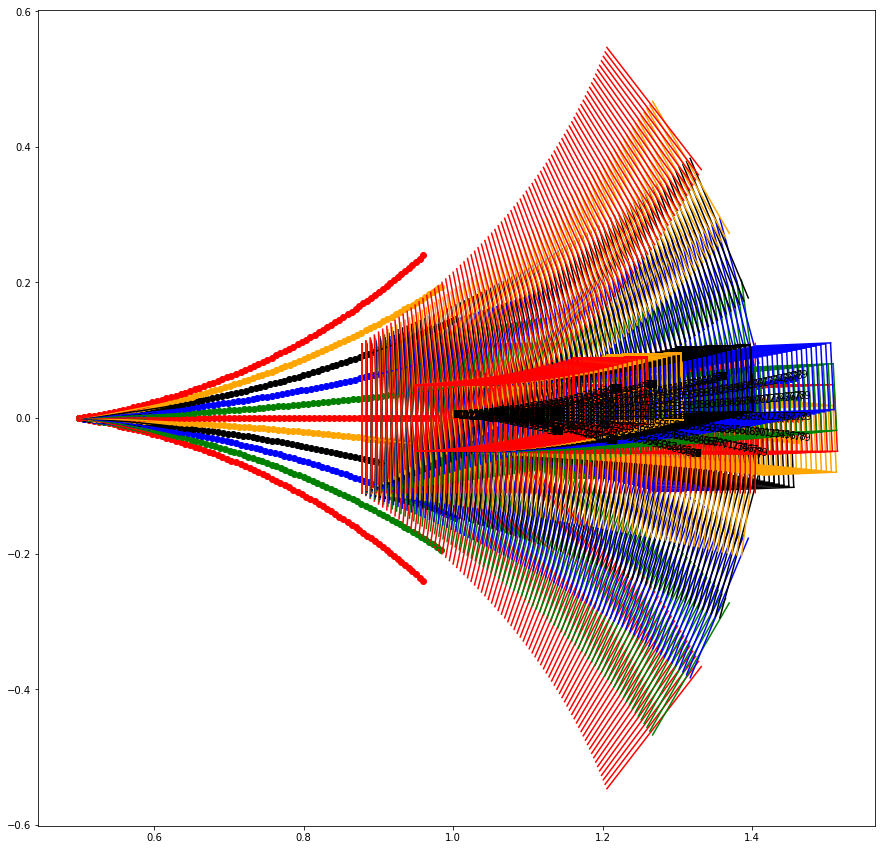

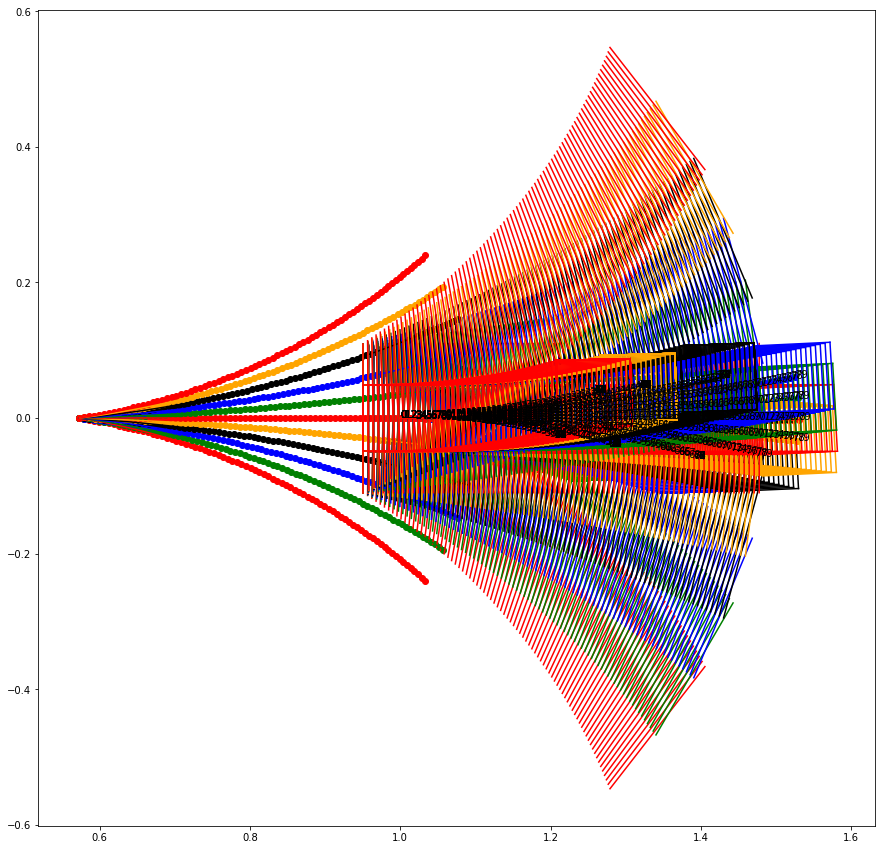

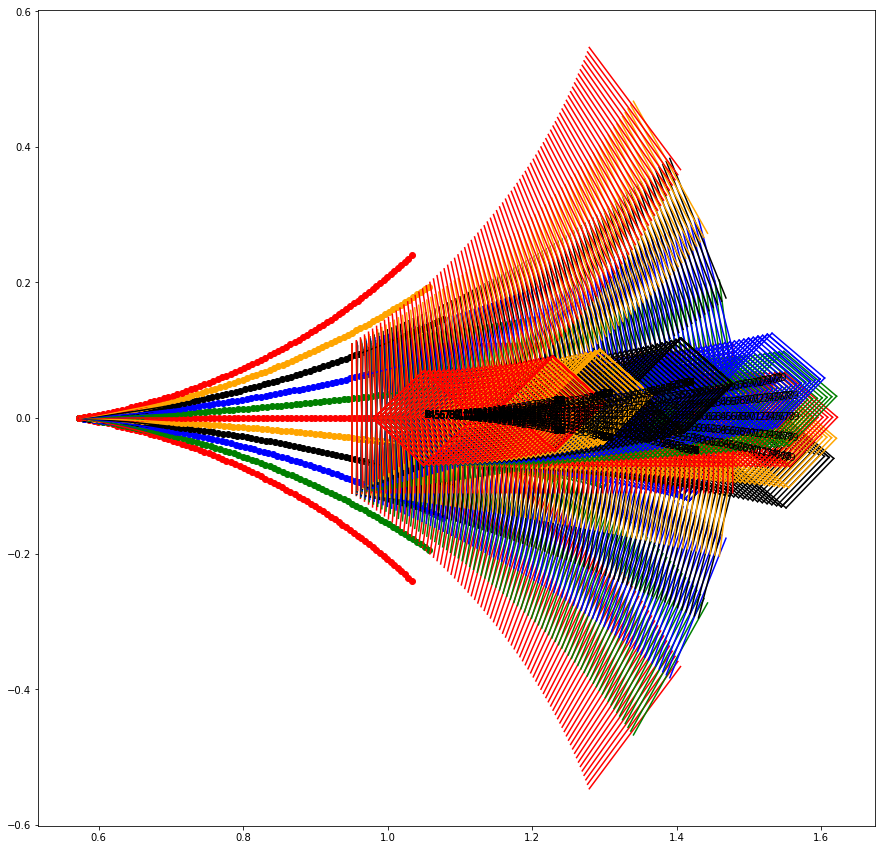

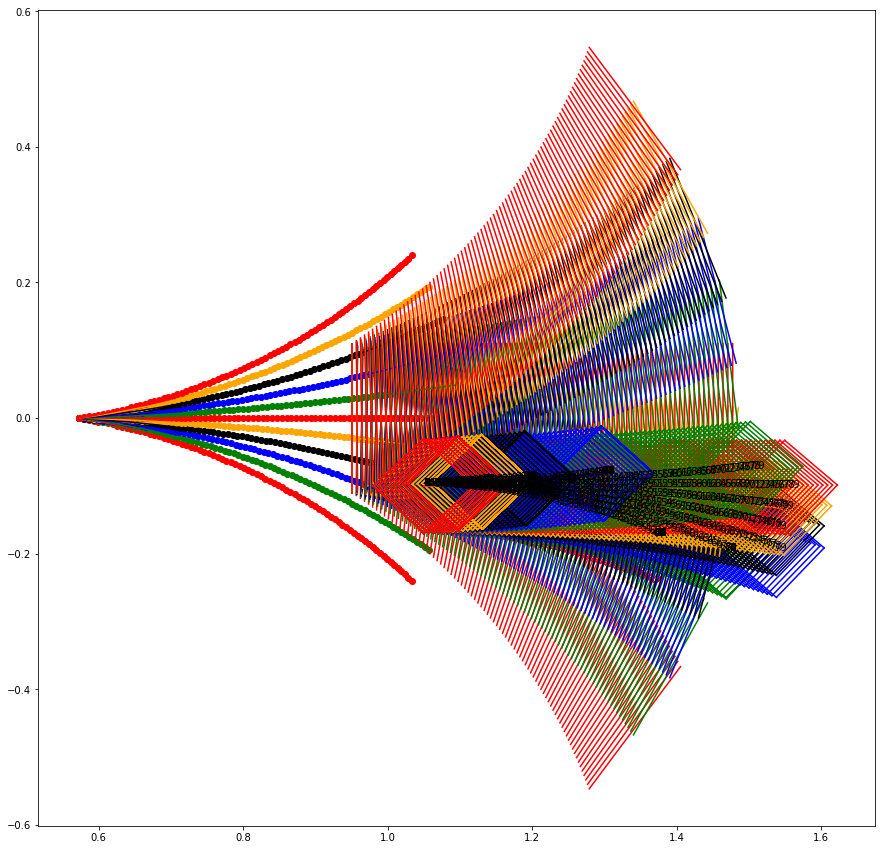

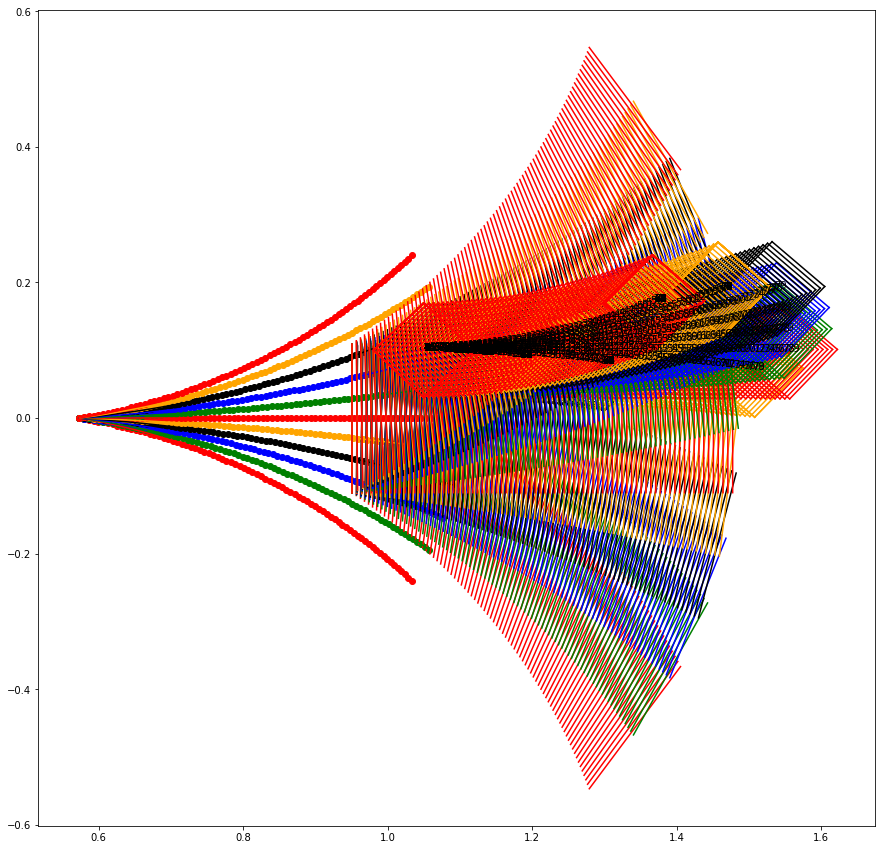

In [71]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import train_pipeline.plotting

colors = ["red", "green", "blue", "black", "orange"]
arrows = True

xd = push_measures_yaml["x_pusher_pos_base_link"]
xb = float(push_measures_yaml["block_side_len"]) / 2.0
offset = 1.0 - xd - xb

test_traj = [
    torch.FloatTensor([0.5, 0.0, 0.0, 1.0, 0.0, 0]),
    torch.FloatTensor([offset, 0.0, 0.0, 1.0, 0.0, 0]),
    torch.FloatTensor([offset, 0.0, 0.0, 1.05, 0.0, math.pi/4]),
    torch.FloatTensor([offset, 0.0, 0.0, 1.05, -0.1, math.pi/4]),
    torch.FloatTensor([offset, 0.0, 0.0, 1.05, 0.1, math.pi/4]),
]

#for xd in np.arange(0.29, .6, 0.08):
t = traj_gen.get_control_trajectories(0.4)
for pose in test_traj:

    rollouts = torch.FloatTensor(K, T, 6)

    cov=gpr.rollout(pose, t, rollouts)

    plt.figure(figsize=(15,15))
    i = 0
    for r in rollouts:
        #plt.figure(figsize=(15, 5))
        #plt.subplot(3, 2, i+1)
        plt.scatter(r[:, 0], r[:, 1], color=colors[i % len(colors)])

        plt.plot(r[:, 0], r[:, 1], color=colors[i % len(colors)])
        for p in r:
            train_pipeline.plotting.plot_pusher(plt.gca(), p[0], p[1], p[2], push_measures_yaml, colors[i % len(colors)])

        #plt.scatter(rollouts[:, 0, 3], rollouts[:, 0, 4], color="red")

        if arrows:
            al = 0.005
            for p in r:
                # print p[3], p[4], al * torch.cos(p[5]), al * torch.sin(p[5])
                #plt.arrow(p[3], p[4], al * torch.cos(p[5]), al * torch.sin(p[5]), color="black", width=0.00005)
                train_pipeline.plotting.plot_block(plt.gca(), p[3], p[4], p[5], push_measures_yaml, colors[i % len(colors)])

        plt.scatter(r[:, 3], r[:, 4], color=colors[i % len(colors)])

        ax = plt.gca()

        for j in range(len(r)):
            ax.annotate(j, (r[j, 3], r[j, 4]))

        plt.plot(r[:, 3], r[:, 4], color=colors[i % len(colors)])
        i+=1